In [4]:

try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # Ensure LogisticRegression is imported
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint, uniform
import joblib

print("Setup done. Running in Colab:", IN_COLAB)

Setup done. Running in Colab: True


In [2]:

if IN_COLAB:
    print("Please upload CVD_cleaned.csv now.")
    uploaded = files.upload()
    for fn in uploaded:
        print("Uploaded:", fn)
else:
    print("Not running in Colab. Place CVD_cleaned.csv in the working folder.")


Please upload CVD_cleaned.csv now.


Saving CVD_cleaned.csv to CVD_cleaned.csv
Uploaded: CVD_cleaned.csv


In [5]:

candidates = ['CVD_cleaned.csv', '/content/CVD_cleaned.csv', '/mnt/data/CVD_cleaned.csv', 'CVD.csv']
df = None
for p in candidates:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print('Loaded:', p)
        break
if df is None:
    raise FileNotFoundError("CVD_cleaned.csv not found. Upload it or place it in the working dir.")

print("\nShape:", df.shape)
display(df.head())
print("\nColumn types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())



Loaded: CVD_cleaned.csv

Shape: (308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0



Column types:
 General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                       int64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption               int64
Fruit_Consumption                 int64
Green_Vegetables_Consumption      int64
FriedPotato_Consumption           int64
dtype: object

Missing values per column:
 General_Health                  0
Checkup                         0
Exercise                        0
Heart_Disease                   0
Skin_Cancer                     0
Other_Cance

In [6]:

data = df.copy()

target_col = 'Heart_Disease'


X = data.drop(columns=[target_col])
y_raw = data[target_col].astype(str)


le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
print("Target classes:", le_target.classes_)


cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


X_enc = X.copy()
for c in cat_cols:
    vals = [str(v).strip().lower() for v in X_enc[c].unique()]
    if set(['yes', 'no']).issubset(set(vals)):
        X_enc[c] = X_enc[c].map(lambda v: 1 if str(v).strip().lower() == 'yes' else 0)
    else:
        X_enc[c] = LabelEncoder().fit_transform(X_enc[c].astype(str))


scaler = StandardScaler()
X_enc[num_cols] = scaler.fit_transform(X_enc[num_cols])

print("\nSample after encoding and scaling:")
display(X_enc.head())


Target classes: ['No' 'Yes']
Categorical columns: ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']
Numeric columns: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

Sample after encoding and scaling:


,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,2,0,0,0,0,0,1,0,10,-1.934250,-2.386180,-2.159696,1,-0.621527,0.006625,0.059597,0.664502
1,4,4,0,0,0,0,1,0,0,10,-0.526857,-0.303547,-0.051548,0,-0.621527,0.006625,-1.012342,-0.267579
2,4,4,1,0,0,0,1,0,0,8,-0.714510,0.227770,0.742649,0,-0.133707,-0.716973,-0.811354,1.130543
3,3,4,1,0,0,0,1,0,1,11,0.880535,0.461569,0.015913,0,-0.621527,0.006625,0.997544,0.198462
4,2,4,0,0,0,0,0,0,1,12,1.912623,0.227770,-0.652562,1,-0.621527,-0.877772,-0.744358,-0.733620


In [7]:
# Step 5 — Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))



Train shape: (247083, 18)
Test shape: (61771, 18)
Train class counts: [227106  19977]
Test class counts: [56777  4994]


In [8]:

from sklearn.svm import LinearSVC

results = {}


print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['LogisticRegression'] = {
    'model': lr,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'y_pred': y_pred_lr
}
print("Logistic Regression accuracy:", results['LogisticRegression']['accuracy'])


print("\nTraining Random Forest...")
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['RandomForest'] = {
    'model': rf,
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'y_pred': y_pred_rf
}
print("Random Forest accuracy:", results['RandomForest']['accuracy'])


print("\nTraining LinearSVC (fast SVM)...")
lsvc = LinearSVC(max_iter=10000, dual=False, random_state=42)
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_test)
results['LinearSVM'] = {
    'model': lsvc,
    'accuracy': accuracy_score(y_test, y_pred_lsvc),
    'y_pred': y_pred_lsvc
}
print("LinearSVM accuracy:", results['LinearSVM']['accuracy'])


for name, info in results.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", info['accuracy'])
    print("Classification Report:\n", classification_report(y_test, info['y_pred'], target_names=le_target.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, info['y_pred']))



Training Logistic Regression...
Logistic Regression accuracy: 0.9189911123342669

Training Random Forest...
Random Forest accuracy: 0.9188130352430752

Training LinearSVC (fast SVM)...
LinearSVM accuracy: 0.9191530005989865

=== LogisticRegression ===
Accuracy: 0.9189911123342669
Classification Report:
               precision    recall  f1-score   support

          No       0.92      1.00      0.96     56777
         Yes       0.48      0.03      0.05      4994

    accuracy                           0.92     61771
   macro avg       0.70      0.51      0.51     61771
weighted avg       0.89      0.92      0.88     61771

Confusion Matrix:
 [[56624   153]
 [ 4851   143]]

=== RandomForest ===
Accuracy: 0.9188130352430752
Classification Report:
               precision    recall  f1-score   support

          No       0.92      1.00      0.96     56777
         Yes       0.47      0.03      0.06      4994

    accuracy                           0.92     61771
   macro avg       0.70 

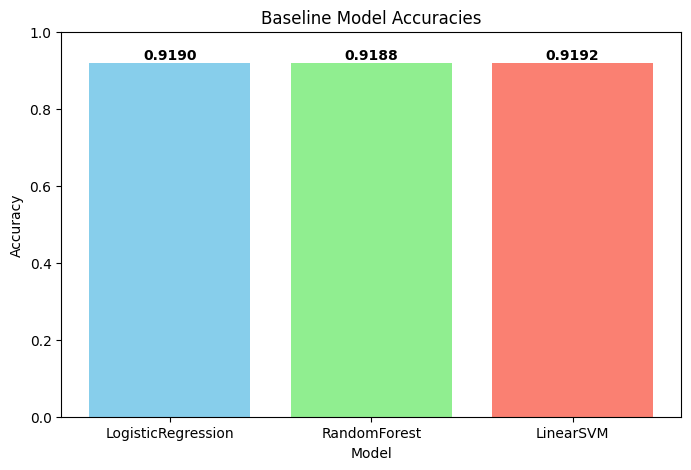

In [9]:

names = list(results.keys())
accs = [results[n]['accuracy'] for n in names]

plt.figure(figsize=(8,5))
plt.bar(names, accs, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title("Baseline Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Model")


for i, v in enumerate(accs):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

plt.show()


In [10]:

print("Creating a small stratified sample (5%) for tuning...")
X_tune, _, y_tune, _ = train_test_split(X_train, y_train, test_size=0.95, stratify=y_train, random_state=42)
print("Tuning sample size:", X_tune.shape)


from scipy.stats import randint

param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}
rfc = RandomForestClassifier(random_state=42)
rscv_rf = RandomizedSearchCV(
    rfc,
    param_distributions=param_dist_rf,
    n_iter=12,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
print("\nTuning RandomForest...")
rscv_rf.fit(X_tune, y_tune)
print("Best RF parameters:", rscv_rf.best_params_)


best_rf = rscv_rf.best_estimator_
best_rf.fit(X_train, y_train)


y_pred_rf_tuned = best_rf.predict(X_test)
print("\nTuned RF accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_tuned, target_names=le_target.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_tuned))


Creating a small stratified sample (5%) for tuning...
Tuning sample size: (12354, 18)

Tuning RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF parameters: {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 237}

Tuned RF accuracy: 0.9191853782519305
Classification Report:
               precision    recall  f1-score   support

          No       0.92      1.00      0.96     56777
         Yes       0.53      0.00      0.01      4994

    accuracy                           0.92     61771
   macro avg       0.72      0.50      0.48     61771
weighted avg       0.89      0.92      0.88     61771

Confusion Matrix:
 [[56759    18]
 [ 4974    20]]


In [11]:


sample_idx = 0
sample = X_test.iloc[[sample_idx]]
actual_label = le_target.inverse_transform([y_test[sample_idx]])[0]

print("Sample index:", sample_idx)
print("Actual Health Status:", actual_label)
print("\nPredictions:")


for name, info in results.items():
    pred = info['model'].predict(sample)[0]
    print(f"{name}: {le_target.inverse_transform([pred])[0]}")


pred_tuned_rf = best_rf.predict(sample)[0]
print(f"Tuned RandomForest: {le_target.inverse_transform([pred_tuned_rf])[0]}")


Sample index: 0
Actual Health Status: No

Predictions:
LogisticRegression: No
RandomForest: No
LinearSVM: No
Tuned RandomForest: No
